<a href="https://colab.research.google.com/github/vijayakuruba/IFT6390_Text-Generation/blob/main/IFT_6390_Final_Project_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6390: Final Project

The final project pertains to the problem of finding novel [antimicrobial peptides](https://en.wikipedia.org/wiki/Antimicrobial_peptides) (AMP) which may turn out to be key in the fight against antibiotics resistance. The World Health Organization qualifies antibiotic resistance as one of the [''biggest threats to global health, food security, and development today''](https://www.who.int/news-room/fact-sheets/detail/antibiotic-resistance).

Given the limited time frame of this project, I have scoped down the problems to two main tracks:

1. **Classification**: classifying protein sequences as AMP or non-AMP: a binary classification problem
  1.1 You are allowed to use Scikit-learn. You need to provide the following baselines: Random Forest, SVM, Neural Network. Use TF-IDF as a baseline feature extractor (you can use sklearn) for each of those.  
2. **Generation**: Given a corpus of AMP sequences, learn a character-level language model. You should implement a baseline using a Markov model. Then implement a sequential model using an RNN or LSTM. 

You should pick one of the two options. Choose your own adventure. You can work in teams of **three people max**.

# Dataset

The dataset in this project comes from two open source projects: amPEPpy and AMPlify.

In [1]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

     |████████████████████████████████| 2.3MB 8.0MB/s 
--2021-04-20 01:30:22--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166037 (162K) [text/plain]
Saving to: ‘AMP_20190407.fa’

AMP_20190407.fa     100%[===================>] 162.15K  --.-KB/s    in 0.02s   

2021-04-20 01:30:22 (10.1 MB/s) - ‘AMP_20190407.fa’ saved [166037/166037]

--2021-04-20 01:30:23--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

In [2]:
from Bio import SeqIO
import matplotlib.pyplot as plt

In [3]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [4]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

Once we have merged the two data sources, the positive class has:

In [ ]:
print(f"{len(positive_examples)} examples")

5264 examples


and the negative class (non-AMPs) has:

In [ ]:
print(f"{len(negative_examples)} examples")

167732 examples


We have way more non-AMPs than AMP. This will be a challenge. Furthermore, the distribution of the sequence lengths varies a lot between the two classes. You should probably do something about this.

Text(0.5, 1.0, 'Negative Sequence Lengths')

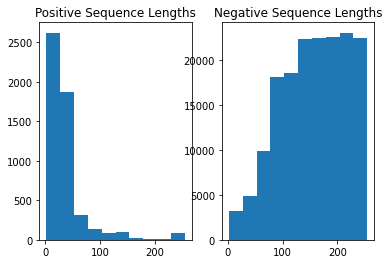

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

Let's have a look at the data. For example, the first AMP in the dataset is:

In [6]:
list(positive_examples)[0]

'TKKFPNRRKTAFCSNWNQKIKTV'

This string describes the sequence of [amino acids](https://en.wikipedia.org/wiki/Amino_acid) present in the given AMP. There are $20$ possible such *standard* amino acids present in the genetic code. To know more about the meaning of each of those letter, see [this section](https://en.wikipedia.org/wiki/Amino_acid#Table_of_standard_amino_acid_abbreviations_and_properties) of the Wikipedia page on amino acids.

A non-AMP looks like:

In [10]:
list(negative_examples)[0]

'MVNYPSGVRAGGYPQKKKNQNIRYGKRGMGLEEMINQANDYYLVNHQAVIHKKPTPITVVHVDYPDRSMAKITEAYYVQPSTTDYNGVVSGKYIDFDAKETKNKTNMPLKNFHQHQITHLKNVLENGGIGFLVLGFTTLSEYYIFPASLLIKIWDKAKAGGEKSLPYKIVSKQGIKINSKMIPSLDYLPALKKLFNI'

In [5]:
import pandas as pd 
df_p=pd.DataFrame(positive_examples,columns=['Sequences'])
df_p['Labels']=1
df_n=pd.DataFrame(negative_examples,columns=['Sequences'])
df_n['Labels']=0


In [6]:
print('positive_examples shape is:', df_p.shape)
print('negative_examples shape is:', df_n.shape)

positive_examples shape is: (5264, 2)
negative_examples shape is: (167732, 2)


In [7]:
df=pd.DataFrame()
df=df.append(df_p,ignore_index=True)
df=df.append(df_n,ignore_index=True)
df

,Sequences,Labels
0,GLFSKFAGKGIKNFLIEGVKHIGKEVGMDVIRTGIDVAGCKIKGEC,1
1,GLVTSLIKGAGKLLGGLFGSVTG,1
2,GLFSVLGSVAKHVVPRVVPVIAEHLG,1
3,DAECEICKFVIQQVEAFIESNHSQAEIQKELNKLCSSVPSITQTCL...,1
4,GLPCGETTCFTGKCYTPGCSCSYPICKKIN,1
...,...,...
172991,MTLNLRVMTPNRTVWNSEVQEMILSTNSGQIGVLPNHAPLLTALDI...,0
172992,MNDYIVVKCGGSMLDQLNDVFFDCIKKLQQQYKVVIVHGGGPEIDA...,0
172993,MAIVSKGILGKKVGMTQVFTEEGHLIPVTVVEAGPCYVIQKKTKAT...,0
172994,IWYLFRDNLLPRNTKFIGYARTKQTLAEVKEKCKKYIKVRTGEEDK...,0


In [8]:
! pip install nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
import nltk 
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

# get stop words from nltk
stopWords = stopwords.words('english')

# pre processing data
def cleanData(sentence):
    processedList = ""
    
# Tokenize words
    sentence=nltk.word_tokenize(sentence)

    
    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
cleanData(df['Sequences'][2])

['ISCQDVKQSLAPCLPYVTGRAPKPA']

In [10]:
# clean data 
df['Sequences'] = df['Sequences'].map(lambda x: cleanData(x))

In [11]:
df['Sequences'] 

0          [GLFSKFAGKGIKNFLIEGVKHIGKEVGMDVIRTGIDVAGCKIKGEC]
1                                 [GLVTSLIKGAGKLLGGLFGSVTG]
2                              [GLFSVLGSVAKHVVPRVVPVIAEHLG]
3         [DAECEICKFVIQQVEAFIESNHSQAEIQKELNKLCSSVPSITQTC...
4                          [GLPCGETTCFTGKCYTPGCSCSYPICKKIN]
                                ...                        
172991    [MTLNLRVMTPNRTVWNSEVQEMILSTNSGQIGVLPNHAPLLTALD...
172992    [MNDYIVVKCGGSMLDQLNDVFFDCIKKLQQQYKVVIVHGGGPEID...
172993    [MAIVSKGILGKKVGMTQVFTEEGHLIPVTVVEAGPCYVIQKKTKA...
172994    [IWYLFRDNLLPRNTKFIGYARTKQTLAEVKEKCKKYIKVRTGEED...
172995    [MNSGTKLKVKWIMMAYTLQTIREKELILHYLALMLKDLAELDCGL...
Name: Sequences, Length: 172996, dtype: object

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

X=df['Sequences'] 
y=df['Labels'] 

def dummy(doc):
    return doc

vectorizer = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,lowercase=False,max_features=5000)

vectorizer.fit(X)

x_transform = vectorizer.transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
import numpy as np

TFIDF_mean = np.mean(x_transform, axis=0)

TFIDF_mean 
TFIDF_mean = np.array(TFIDF_mean)[0].tolist()

# Feature_importance=top_feats(TFIDF_mean ,Word, Imp_Feat)

topn_ids = np.argsort(TFIDF_mean)[::-1][:1000]
names = np.array(word)
# print(names[topn_ids])
top_feats = [(word[i], TFIDF_mean[i]) for i in topn_ids]
df_feat = pd.DataFrame(top_feats, index=names[topn_ids])
df_feat.columns = ['FEATURE', 'Feat_IMP_value']

Feature_importance = df_feat
df_feat[:150].plot.bar(y='Feat_IMP_value', title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')
New_FI_index = Feature_importance.reset_index()
del New_FI_index['index']
plt.show()
#plt.savefig('feature_Importance.png')

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_transform , y,
    stratify=y, 
    test_size=0.2, shuffle=True)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfs = RandomForestClassifier()
rfs.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
Z = rfs.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test, Z)

0.9651156069364162

Saved files as 2 categories as text files

In [ ]:
!mkdir data_seq
!cd data_seq

In [ ]:
import pandas as pd 


positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta')) 

df_p=pd.DataFrame(positive_examples)
df_p.to_csv(r'/content/data_seq/positive_examples.txt', header=None, index=None, sep='\t', mode='a')

df_n=pd.DataFrame(positive_examples)
df_n.to_csv(r'/content/data_seq/negative_examples.txt', header=None, index=None, sep='\t', mode='a')


# Data Preprocessing


In [ ]:
#To Implement

# Accessing Data 

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data_seq/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'the current directory.')

print('# categories:', n_categories, all_categories)
#print(category_lines['positive_examples'])

# categories: 2 ['positive_examples', 'negative_examples']


#BASELINE MARKOV CHAIN

In [ ]:
#To Implement

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    #print(category,line)
    return category, line
  

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

#RNN

This network extends the last tutorial's RNN <#Creating-the-Network>__ with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which randomly zeros parts of its input <https://arxiv.org/abs/1207.0580>__ with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png :alt:

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000
print_every = 500
plot_every = 50
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    print(output, loss)

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




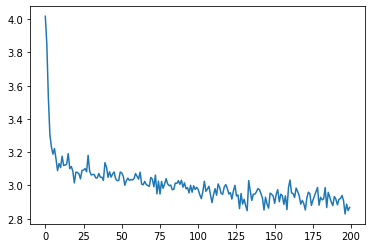

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [ ]:
max_length = 100

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='MNP'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('positive_examples', 'MNP')

samples('negative_examples', 'MNP')



MLPPIPKPIPPPIPPPIGKCLKKILKKILKKLLKKLAKKLLKKLLKKLLKKLLKKLLKKLLKKLLKKLLKKLLKKLLKKLLKGLGKGLGGLLKKLLKKLLK
NLPPIPPPPPRPPPPPPCPPPPPPCPPPPPPPPPPPPPPPPPPPRPPPPPPPPPPPRPPPPPPPPPPPPPRPPPPRPPPPPPPPPPPPPPPPPPPPPPPPP
PLPPPPPPPRPPPPRPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPRRPPPRPPPPPPPPPPPPPRPPPPPPPPPPPPPPPPPP
MLPGILKKIGKKLGKGLGKLLKKLLKKLAGKLAGKAAKKVAKKAAKKAAKKAAKKAAKKAAKKAAKKAAKKAAKGLGKGLGKLLKKLLKNLGKGLGKLLKK
NLPPILKGLGKGLKKAAKKAAKKAAGKAAKKAAKKAAKKAAKKAAKKAGKKAGKGLGKGLGKLAKKIAKKLAKKAAKKAAKKAAGKAAGKAAKGAAKKAAK
PLPPPLPPIPKKIGKKIGKGLGKLLKKLLKKAAKGLGKGLGKLAGKAAKKAAKKALKKAAKKVAKKAAKKAAKGLGKKLGKGLKKAAKKAAGKAAKKAAKK
